In [1]:
import io
import re
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Semon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
elon_df = pd.read_csv('data/elon_prepared_tweets_transformer.csv', index_col='id')
elon_df.head()

,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V759,V760,V761,V762,V763,V764,V765,V766,V767,V768
id,,,,,,,,,,,,,,,,,,,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,this is a pretty awful lie i left south africa...,0.008623,-0.038959,-0.064938,-0.065588,-0.066482,0.041533,-0.046693,...,0.000482,0.031413,-0.018700,0.015388,0.007253,-0.021971,0.013284,-0.064772,-0.061415,0.006583
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,this person blocked me so can t read the tweet...,-0.021382,0.033233,-0.019205,-0.063174,0.038882,0.045739,-0.050074,...,0.042554,-0.046082,-0.046342,0.020049,-0.061177,0.057064,-0.056571,-0.003063,0.036571,0.006675
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,we started zip2 with 2k from me plus my overcl...,0.007762,-0.028661,-0.041164,-0.054028,-0.016149,0.003040,-0.039877,...,0.054301,-0.044400,-0.031991,0.021364,-0.007534,-0.032499,-0.031120,0.003252,-0.049795,0.030920
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,he didn t own an emerald mine i worked my way ...,-0.032627,-0.034146,-0.067866,-0.067204,-0.046921,0.024160,-0.069717,...,0.058897,-0.004664,-0.013007,0.039658,-0.023990,0.011486,0.028584,-0.055376,-0.025286,0.007455
1211051740562366464,@geofficient Pretty much,2019-12-28,pretty much,0.029701,-0.054455,-0.056146,-0.058670,-0.007973,-0.011959,-0.008488,...,0.011320,0.013753,-0.019156,-0.015933,0.002867,0.034740,-0.044341,-0.023830,-0.021823,0.005620


In [4]:
elon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8643 entries, 1211071324518531072 to 1344810193952014336
Columns: 771 entries, text to V768
dtypes: float64(768), object(3)
memory usage: 50.9+ MB


In [6]:
text_embeddings = elon_df[filter(lambda c: c.startswith('V'), elon_df.columns)]
text_embeddings.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V759,V760,V761,V762,V763,V764,V765,V766,V767,V768
id,,,,,,,,,,,,,,,,,,,,,
1211071324518531072,0.008623,-0.038959,-0.064938,-0.065588,-0.066482,0.041533,-0.046693,-0.018837,0.052824,0.007191,...,0.000482,0.031413,-0.018700,0.015388,0.007253,-0.021971,0.013284,-0.064772,-0.061415,0.006583
1211069054779301894,-0.021382,0.033233,-0.019205,-0.063174,0.038882,0.045739,-0.050074,-0.036520,-0.035358,0.038591,...,0.042554,-0.046082,-0.046342,0.020049,-0.061177,0.057064,-0.056571,-0.003063,0.036571,0.006675
1211064937004589056,0.007762,-0.028661,-0.041164,-0.054028,-0.016149,0.003040,-0.039877,-0.016086,0.070417,-0.048790,...,0.054301,-0.044400,-0.031991,0.021364,-0.007534,-0.032499,-0.031120,0.003252,-0.049795,0.030920
1211054942192119808,-0.032627,-0.034146,-0.067866,-0.067204,-0.046921,0.024160,-0.069717,0.015351,0.055999,0.007987,...,0.058897,-0.004664,-0.013007,0.039658,-0.023990,0.011486,0.028584,-0.055376,-0.025286,0.007455
1211051740562366464,0.029701,-0.054455,-0.056146,-0.058670,-0.007973,-0.011959,-0.008488,-0.019550,-0.071942,0.005579,...,0.011320,0.013753,-0.019156,-0.015933,0.002867,0.034740,-0.044341,-0.023830,-0.021823,0.005620


In [7]:
%%time
pca = PCA(n_components=2, random_state=42)
text_pca = pca.fit_transform(text_embeddings)
print('PCA done!')

umap = UMAP(n_components=2, n_jobs=-1, random_state=42)
text_umap = umap.fit_transform(text_embeddings)
print('UMAP done!')

umap_cosine = UMAP(n_components=2, n_jobs=-1, metric='cosine', random_state=42)
text_umap_cosine = umap_cosine.fit_transform(text_embeddings)
print('UMAP(cosine) done!')

PCA done!
UMAP done!
UMAP(cosine) done!
CPU times: total: 1min 41s
Wall time: 1min 31s


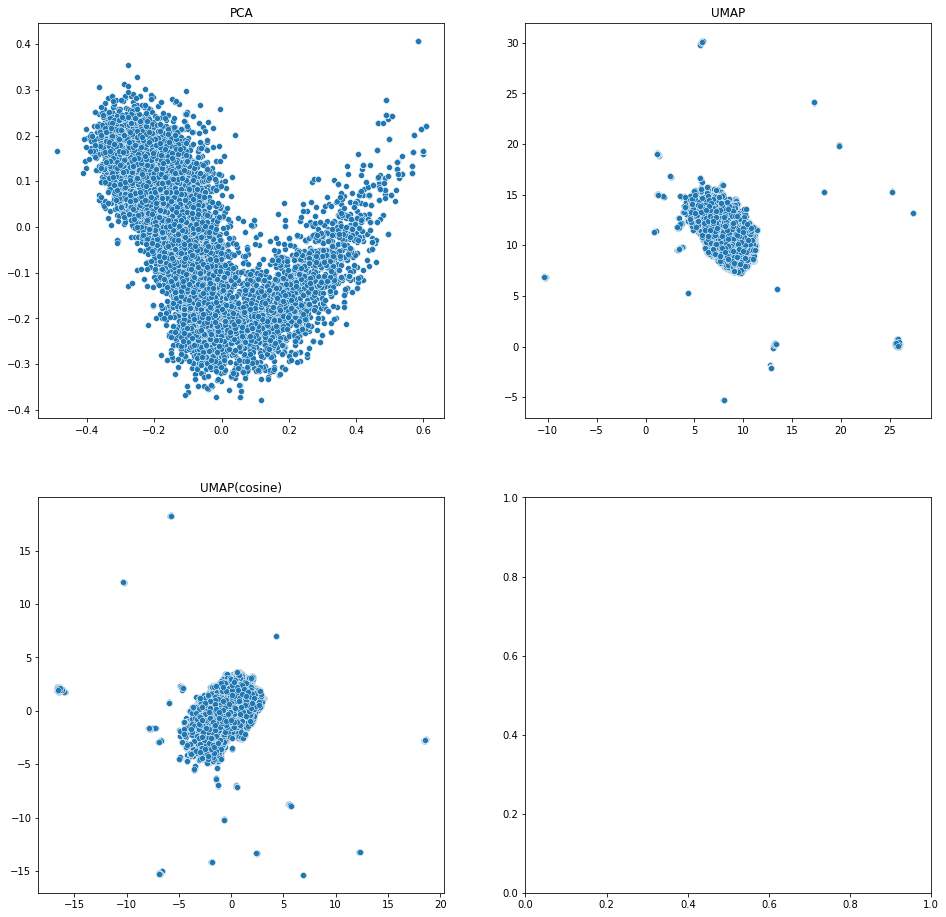

In [8]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21);

In [9]:
K = list(range(1, 16))

inertia = {}
silhouette = {}

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(text_embeddings)
    inertia[k] = kmeans.inertia_
    silhouette[k] = silhouette_score(text_embeddings, kmeans.labels_) if k > 1 else None

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:47<00:00,  7.19s/it]


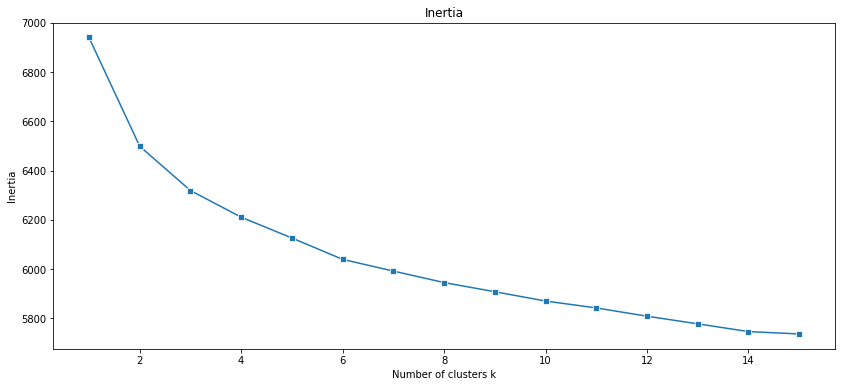

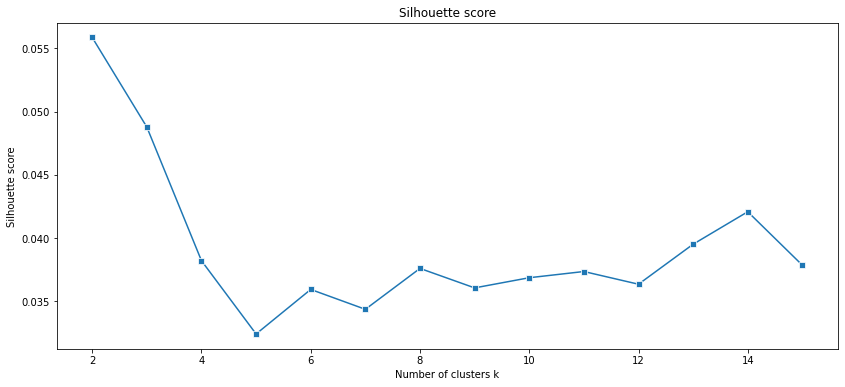

In [10]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[inertia[k] for k in K], marker='s')

plt.title('Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [11]:
d = {}
for k in K[1:-1]:
    d[k] = (inertia[k] - inertia[k + 1]) / (inertia[k - 1] - inertia[k])

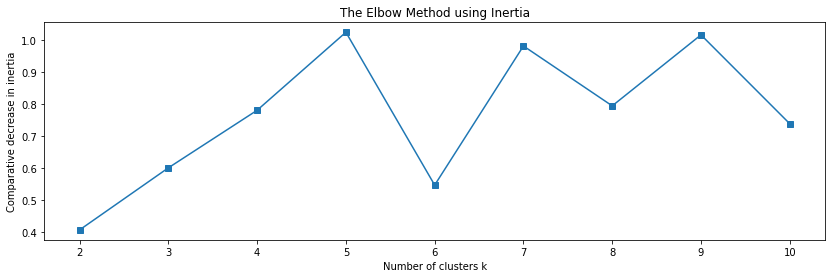

In [12]:
plt.figure(figsize=(14, 4))
plt.plot(list(d.keys())[:9], list(d.values())[:9], marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

In [18]:
kmeans = KMeans(
    n_clusters=2,
    # eps=0.6,
    # metric='cosine',
    random_state=42
)
clusters = kmeans.fit_predict(text_embeddings)
# clusters = kmeans.fit_predict(text_pca)
print(len(set(clusters)))

2


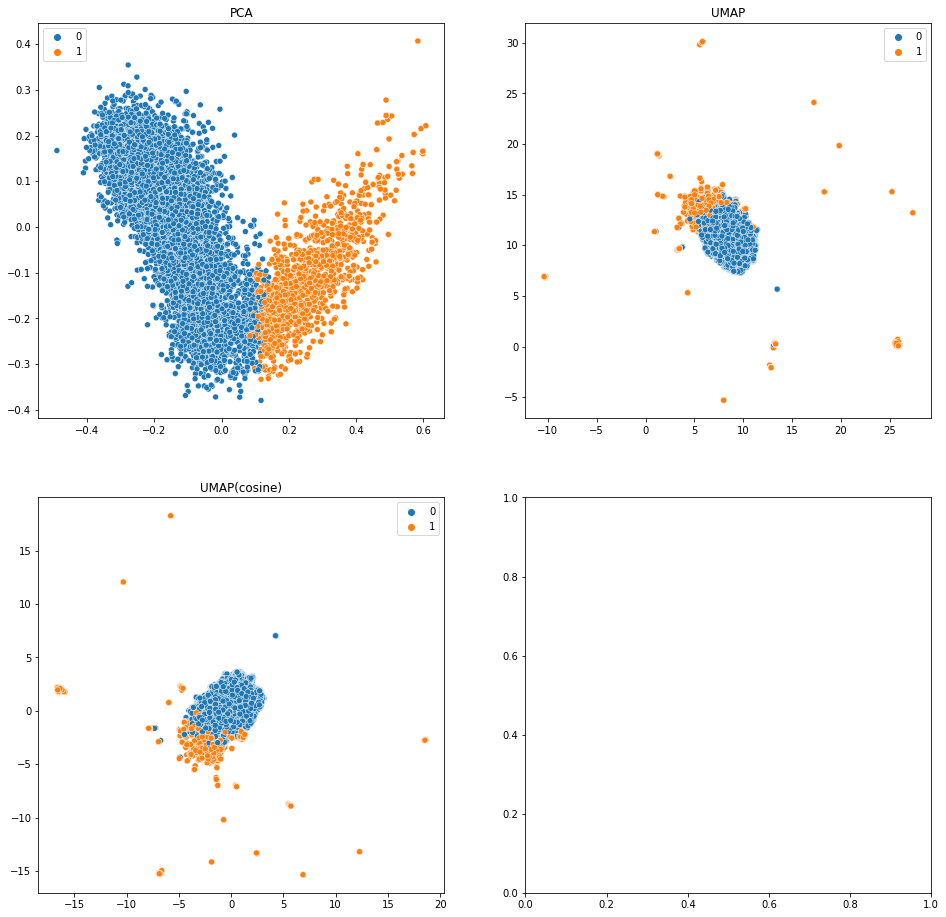

In [19]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=clusters);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=clusters);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=clusters);

In [23]:
def print_top_n_words(data: pd.Series, n: int = 25):
    words_counter = collections.Counter()
    data.str.split().apply(words_counter.update)
    return words_counter.most_common(n)

In [24]:
elon_df['cluster'] = clusters
elon_df.groupby('cluster')['cluster'].count()

cluster
0    6318
1    2325
Name: cluster, dtype: int64

In [26]:
for cluster in set(elon_df['cluster']):
    print(
        f'Cluster {cluster:3}. {len(elon_df.query(f"cluster == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(elon_df.query(f'cluster == {cluster}').cleared_text, n=10)
    )

Cluster   0.  6318 tweets total. Top-3 words: [('to', 2616), ('is', 2225), ('the', 2186), ('a', 1889), ('of', 1734), ('in', 1336), ('for', 1186), ('it', 1048), ('will', 970), ('be', 950)]
Cluster   1.  2325 tweets total. Top-3 words: [('yes', 240), ('true', 130), ('haha', 116), ('exactly', 97), ('it', 91), ('sure', 87), ('good', 75), ('s', 69), ('great', 59), ('ok', 57)]


In [28]:
cluster = 0

print(print_top_n_words(elon_df.query(f'cluster == {cluster}').text))
elon_df.query(f'cluster == {cluster}').head(10)

[('to', 2556), ('is', 2185), ('the', 1904), ('a', 1798), ('of', 1720), ('&amp;', 1527), ('in', 1256), ('for', 1134), ('be', 945), ('will', 814), ('on', 751), ('with', 700), ('but', 700), ('that', 600), ('are', 591), ('I', 590), ('Tesla', 589), ('it', 512), ('@Erdayastronaut', 494), ('at', 464), ('as', 461), ('this', 440), ('have', 412), ('so', 410), ('we', 386)]


,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V760,V761,V762,V763,V764,V765,V766,V767,V768,cluster
id,,,,,,,,,,,,,,,,,,,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,this is a pretty awful lie i left south africa...,0.008623,-0.038959,-0.064938,-0.065588,-0.066482,0.041533,-0.046693,...,0.031413,-0.018700,0.015388,0.007253,-0.021971,0.013284,-0.064772,-0.061415,0.006583,0
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,this person blocked me so can t read the tweet...,-0.021382,0.033233,-0.019205,-0.063174,0.038882,0.045739,-0.050074,...,-0.046082,-0.046342,0.020049,-0.061177,0.057064,-0.056571,-0.003063,0.036571,0.006675,0
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,we started zip2 with 2k from me plus my overcl...,0.007762,-0.028661,-0.041164,-0.054028,-0.016149,0.003040,-0.039877,...,-0.044400,-0.031991,0.021364,-0.007534,-0.032499,-0.031120,0.003252,-0.049795,0.030920,0
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,he didn t own an emerald mine i worked my way ...,-0.032627,-0.034146,-0.067866,-0.067204,-0.046921,0.024160,-0.069717,...,-0.004664,-0.013007,0.039658,-0.023990,0.011486,0.028584,-0.055376,-0.025286,0.007455,0
1211030194787700736,@justpaulinelol @annerajb Probably 2021. Depen...,2019-12-28,probably 2021 depends on regulatory approvals,0.056185,0.001375,0.032998,-0.051810,-0.010669,0.021190,-0.013547,...,-0.004559,-0.042845,-0.057869,0.026800,-0.021030,0.007814,0.031090,-0.002984,-0.051948,0
1211029491188948992,@annerajb Hopefully working in Caribbean by en...,2019-12-28,hopefully working in caribbean by end of 2020 ...,0.024054,-0.056050,0.010679,-0.030806,-0.012721,0.014142,0.005653,...,0.007034,-0.042157,-0.010812,0.010465,-0.033458,0.007986,0.016759,-0.039780,-0.010709,0
1211010494695391232,@waitbutwhy @Kurz_Gesagt Maximizing conversion...,2019-12-28,maximizing conversion of mass to aimed photons...,-0.041786,0.018446,-0.023810,0.049994,-0.005500,-0.012735,0.024294,...,-0.026488,-0.036541,-0.040109,-0.048128,-0.013539,0.027835,0.034508,0.044283,-0.042667,0
1210777492027363328,"@TheAssassin_95 Yes, but it’s too secret",2019-12-28,yes but it s too secret,-0.036889,-0.058283,-0.024278,-0.056979,-0.040027,-0.003064,-0.045249,...,-0.057221,-0.047831,-0.039835,-0.041256,0.013414,-0.012286,0.000272,-0.051105,-0.043829,0
1210777395738734593,@Erdayastronaut @teslaownersSV @Benioff Hopefu...,2019-12-28,hopefully fully operational in 2020,0.027964,-0.065068,0.006930,-0.003952,-0.042389,0.008162,0.033331,...,0.003805,-0.055463,-0.042724,-0.036624,-0.035696,-0.020284,-0.022107,-0.035038,-0.050913,0


In [29]:
EPS = np.linspace(0.01, 10., 100)

silhouette = {}
clusters = {}

for eps in tqdm(EPS):
    dbscan = DBSCAN(eps=eps, n_jobs=-1).fit(text_embeddings) # metric='cosine' checked
    clusters[eps] = len(set(dbscan.labels_)) - 1
    # print(set(dbscan.labels_))
    if len(set(dbscan.labels_)) > 1:
        # print(eps, set(dbscan.labels_))
        silhouette[eps] = silhouette_score(text_embeddings, dbscan.labels_)
# print(silhouette

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:29<00:00,  3.90s/it]


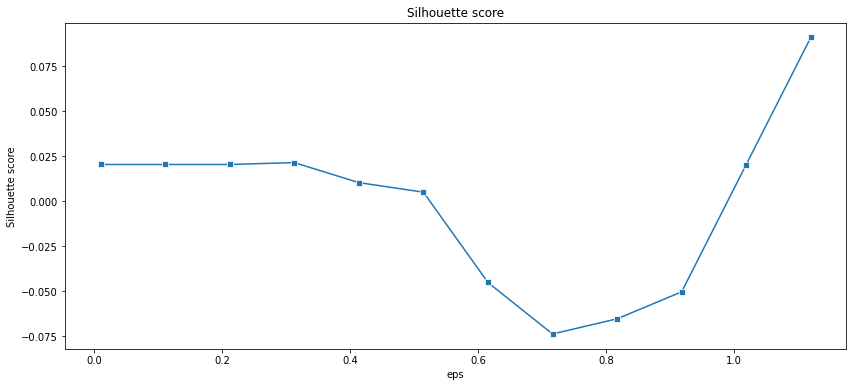

In [30]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[silhouette.get(eps) for eps in EPS], marker='s')

plt.title('Silhouette score')
plt.xlabel('eps')
plt.ylabel('Silhouette score')

plt.show()

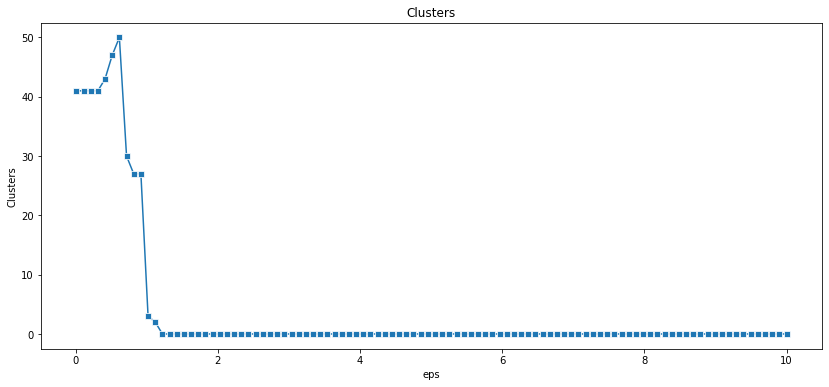

In [31]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=EPS, y=[clusters.get(eps) for eps in EPS], marker='s')

plt.title('Clusters')
plt.xlabel('eps')
plt.ylabel('Clusters')

plt.show()

In [32]:
# best_eps = [*silhouette.keys()][np.argmax([*silhouette.values()])]
best_eps = max({eps for eps, c in clusters.items() if c == 2})
best_eps, clusters.get(best_eps)

(1.1199999999999999, 2)

In [33]:
dbscan = DBSCAN(eps=best_eps, n_jobs=-1) # metric='cosine' checked
elon_df['cluster_dbscan'] = dbscan.fit_predict(text_embeddings)

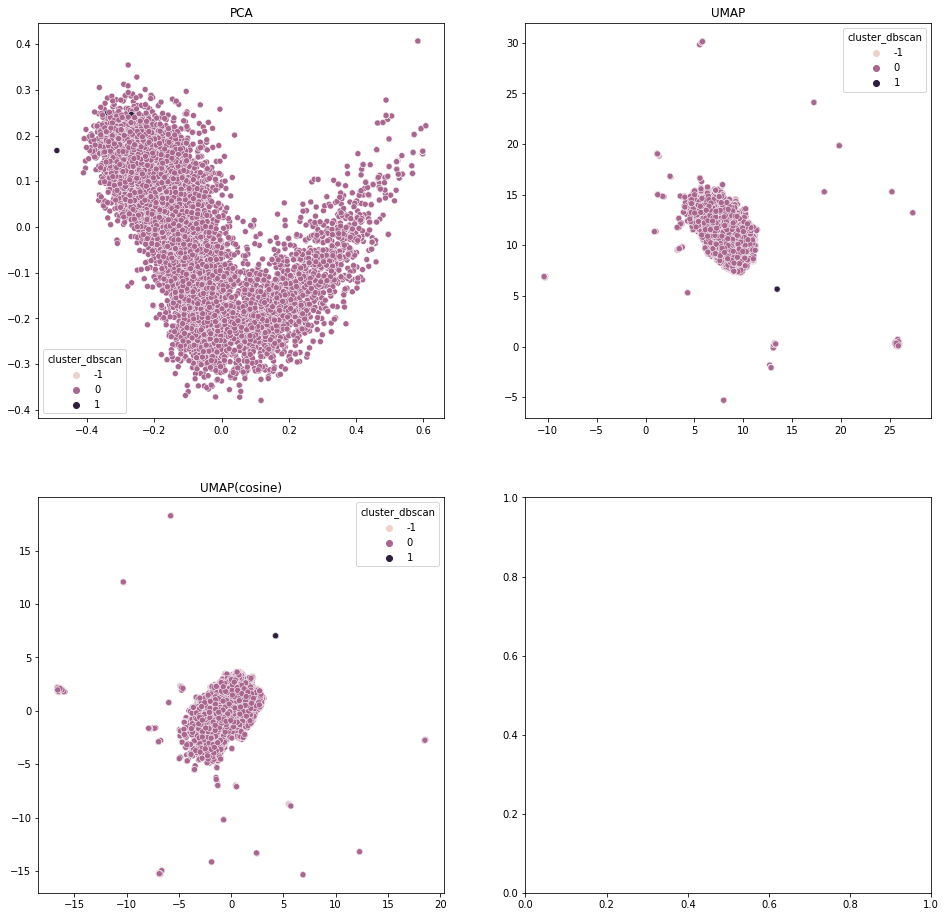

In [34]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=elon_df['cluster_dbscan']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=elon_df['cluster_dbscan']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=elon_df['cluster_dbscan']);

In [35]:
elon_df.groupby('cluster_dbscan')['cluster_dbscan'].count()

cluster_dbscan
-1       1
 0    8636
 1       6
Name: cluster_dbscan, dtype: int64

In [36]:
for cluster in set(elon_df['cluster_dbscan']):
    print(
        f'Cluster {cluster:3}. {len(elon_df.query(f"cluster_dbscan == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(elon_df.query(f'cluster_dbscan == {cluster}').cleared_text, n=3)
    )

Cluster   0.  8636 tweets total. Top-3 words: [('to', 2636), ('is', 2276), ('the', 2239)]
Cluster   1.     6 tweets total. Top-3 words: [('hāhā', 1), ('wārløq', 1), ('møtør', 1)]
Cluster  -1.     1 tweets total. Top-3 words: [('phenolic', 1), ('impregnated', 1), ('carbon', 1)]


In [37]:
cluster = -1

print(print_top_n_words(elon_df.query(f'cluster_dbscan == {cluster}').text))
elon_df.query(f'cluster_dbscan == {cluster}').head(10)

[('@YoBigBrotha', 1), ('Phenolic', 1), ('impregnated', 1), ('carbon', 1), ('ablator,', 1), ('version', 1), ('3', 1)]


,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V761,V762,V763,V764,V765,V766,V767,V768,cluster,cluster_dbscan
id,,,,,,,,,,,,,,,,,,,,,
1104091386230403072,@YoBigBrotha Phenolic impregnated carbon ablat...,2019-03-08,phenolic impregnated carbon ablator version 3,0.011846,-0.01295,-0.04621,0.050262,-0.002633,-0.052101,-0.009474,...,-0.058876,-0.015492,-0.030689,0.020968,-0.024631,0.018431,0.005696,-0.034569,0,-1


In [38]:
K = list(range(2, 50))

silhouette = {}

for k in tqdm(K):
    aggl = AgglomerativeClustering(n_clusters=k).fit(text_embeddings)
    silhouette[k] = silhouette_score(text_embeddings, aggl.labels_) if k > 1 else None

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [27:11<00:00, 33.98s/it]


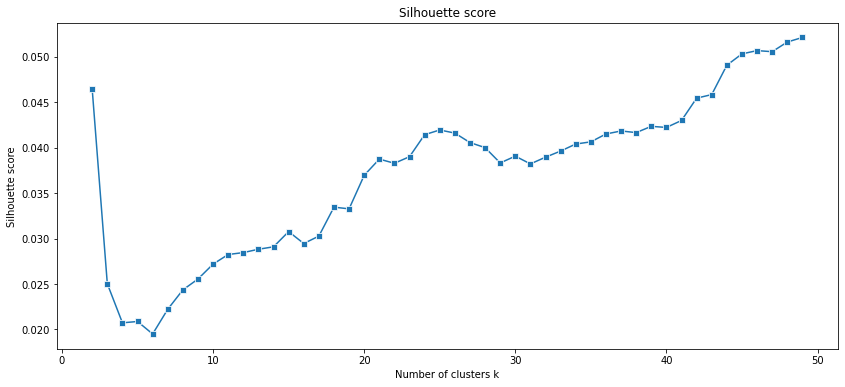

In [39]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=K, y=[silhouette[k] for k in K], marker='s')

plt.title('Silhouette score')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')

plt.show()

In [40]:
best_k = [*silhouette.keys()][np.argmax([*silhouette.values()])]
best_k

49

In [41]:
%%time
agglomerative = AgglomerativeClustering(n_clusters=best_k)
elon_df['cluster_agglom'] = agglomerative.fit_predict(text_embeddings)

CPU times: total: 30.3 s
Wall time: 31 s


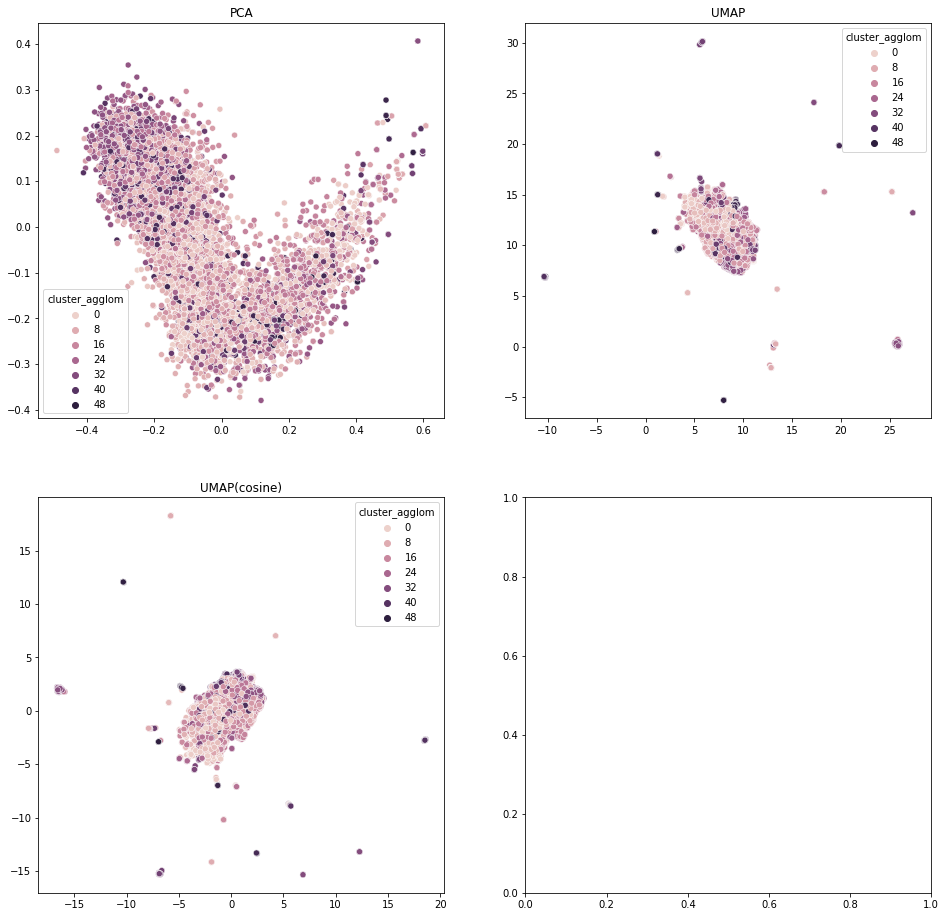

In [42]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(16, 16))

ax11.set_title('PCA')
sns.scatterplot(x=text_pca[..., 0], y=text_pca[..., 1], ax=ax11, hue=elon_df['cluster_agglom']);

ax12.set_title('UMAP')
sns.scatterplot(x=text_umap[..., 0], y=text_umap[..., 1], ax=ax12, hue=elon_df['cluster_agglom']);

ax21.set_title('UMAP(cosine)')
sns.scatterplot(x=text_umap_cosine[..., 0], y=text_umap_cosine[..., 1], ax=ax21, hue=elon_df['cluster_agglom']);

In [43]:
elon_df.groupby('cluster_agglom')['cluster_agglom'].count()

cluster_agglom
0     356
1     270
2     674
3     223
4     353
5      56
6     354
7     638
8     124
9     233
10    126
11    285
12    161
13    112
14    673
15    136
16    113
17    104
18    265
19    290
20    296
21     48
22     44
23     79
24     63
25    227
26     29
27     68
28     88
29    383
30    188
31    215
32     47
33     51
34     98
35    100
36    143
37     86
38    170
39     60
40    106
41     71
42    135
43     41
44    119
45     40
46     42
47     42
48     18
Name: cluster_agglom, dtype: int64

In [44]:
for cluster in set(elon_df['cluster_agglom']):
    print(
        f'Cluster {cluster:3}. {len(elon_df.query(f"cluster_agglom == {cluster}")):5} tweets total. Top-3 words:', 
        print_top_n_words(elon_df.query(f'cluster_agglom == {cluster}').cleared_text, n=3)
    )

Cluster   0.   356 tweets total. Top-3 words: [('it', 63), ('we', 62), ('a', 59)]
Cluster   1.   270 tweets total. Top-3 words: [('it', 16), ('sigh', 11), ('important', 10)]
Cluster   2.   674 tweets total. Top-3 words: [('the', 219), ('to', 166), ('a', 146)]
Cluster   3.   223 tweets total. Top-3 words: [('to', 148), ('of', 147), ('the', 147)]
Cluster   4.   353 tweets total. Top-3 words: [('the', 40), ('of', 33), ('a', 28)]
Cluster   5.    56 tweets total. Top-3 words: [('congratulations', 14), ('you', 14), ('re', 11)]
Cluster   6.   354 tweets total. Top-3 words: [('to', 262), ('is', 239), ('the', 213)]
Cluster   7.   638 tweets total. Top-3 words: [('is', 167), ('the', 152), ('a', 88)]
Cluster   8.   124 tweets total. Top-3 words: [('sure', 68), ('absolutely', 35), ('for', 16)]
Cluster   9.   233 tweets total. Top-3 words: [('starship', 69), ('to', 61), ('the', 45)]
Cluster  10.   126 tweets total. Top-3 words: [('haha', 36), ('right', 22), ('is', 21)]
Cluster  11.   285 tweets tot

In [45]:
cluster = 5

print('Entries:', len(elon_df.query(f'cluster_agglom == {cluster}')))
print(print_top_n_words(elon_df.query(f'cluster_agglom == {cluster}').text))
elon_df.query(f'cluster_agglom == {cluster}').head(10)#.text.apply(text_preprocessor)

Entries: 56
[('@Tesla', 11), ('Congratulations!', 10), ('Agreed', 10), ('Glad', 8), ('Congrats!', 7), ('You’re', 6), ('you’re', 5), ('@NASA', 5), ('welcome!', 5), ('agree', 5), ('@SpaceX', 4), ('ok!', 3), ('you', 3), ('like', 3), ('I', 3), ('Congratulations', 3), ('much', 3), ('@flcnhvy', 2), ('@JAXA_en', 2), ('most', 2), ('@ID_AA_Carmack', 2), ('it', 2), ('@haya2e_jaxa', 2), ('@lexfridman', 2), ('with', 2)]


,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V762,V763,V764,V765,V766,V767,V768,cluster,cluster_dbscan,cluster_agglom
id,,,,,,,,,,,,,,,,,,,,,
1194318100893618181,@KenHowery Congratulations!,2019-11-12,congratulations,0.026368,-0.046153,0.000069,-0.061975,0.056005,-0.000905,0.025144,...,-0.070014,0.004508,-0.025513,-0.033828,0.024400,0.001711,-0.005143,1,0,5
1181070766101549056,@jesterpb @yukaichou @Tesla Agreed,2019-10-07,agreed,0.010855,0.063784,-0.022601,-0.057914,0.007231,-0.045764,0.043402,...,-0.009068,0.033188,-0.006224,-0.023200,0.042714,-0.048889,-0.071326,1,0,5
1173999553260900352,@TFM312 @Tesla Glad you’re ok!,2019-09-17,glad you re ok,-0.010490,-0.061876,-0.034780,-0.063363,0.015050,-0.042420,0.005221,...,-0.041102,-0.036362,-0.034810,-0.033063,-0.009484,0.017899,0.013466,1,0,5
1172924402461073408,@flcnhvy @hoofhrtd1254 @Teslatunity @Model3Own...,2019-09-14,agreed,0.010855,0.063784,-0.022601,-0.057914,0.007231,-0.045764,0.043402,...,-0.009068,0.033188,-0.006224,-0.023200,0.042714,-0.048889,-0.071326,1,0,5
1157375321139642368,@DrAlahbabi @Space_Station @SpaceX @NASA @esa ...,2019-08-02,you re most welcome,0.052007,-0.056943,-0.012160,-0.065853,0.026974,-0.030636,-0.023743,...,-0.009028,0.002938,-0.045620,-0.059770,-0.012412,-0.028056,0.023173,1,0,5
1148016755429613568,@sudohack16 Agreed,2019-07-07,agreed,0.010855,0.063784,-0.022601,-0.057914,0.007231,-0.045764,0.043402,...,-0.009068,0.033188,-0.006224,-0.023200,0.042714,-0.048889,-0.071326,1,0,5
1113572223581687808,@GaragedoorsGman @SherylCrow @Tesla Agreed,2019-04-03,agreed,0.010855,0.063784,-0.022601,-0.057914,0.007231,-0.045764,0.043402,...,-0.009068,0.033188,-0.006224,-0.023200,0.042714,-0.048889,-0.071326,1,0,5
1108890721937842176,@PennPerspective @Tesla You’re welcome!,2019-03-22,you re welcome,0.036245,-0.056717,-0.023933,-0.069168,0.044405,-0.021154,0.003086,...,-0.023266,0.004423,-0.033916,-0.053071,-0.027322,-0.052631,0.038218,1,0,5
1107369888945831936,@THE_REAL_KEAGAN @Tesla @LikeTeslaKim @BenSull...,2019-03-17,agreed,0.010855,0.063784,-0.022601,-0.057914,0.007231,-0.045764,0.043402,...,-0.009068,0.033188,-0.006224,-0.023200,0.042714,-0.048889,-0.071326,1,0,5
